# Import Libraries

# To Be Moved
---------

In [ ]:
import random

def generate_random_patient_ids(num_ids=10, prefix="P", id_length=6):
    random_ids = []
    for _ in range(num_ids):
        id_number = ''.join([str(random.randint(0, 9)) for _ in range(id_length)])
        random_ids.append(prefix + id_number)
    return random_ids

# Generate 10 random patient IDs
random_patient_ids = generate_random_patient_ids()

for id in random_patient_ids:
    print(id)

-----

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import ticker
import time
import math
import numpy as np
import random
from helpers import load_data

In [3]:
intents_dict = load_data()
n_categories = len(intents_dict)
print(n_categories)

14


In [4]:
for intent in intents_dict:
    print(intent, intents_dict[intent])

greeting ['Hi there', 'How are you', 'Is anyone there?', 'Hello', 'Good day']
goodbye ['Bye', 'See you later', 'Goodbye', 'Nice chatting to you, bye', 'Till next time']
thanks ['Thanks', 'Thank you', "That's helpful", 'Awesome, thanks', 'Thanks for helping me']
noanswer []
options ['How you could help me?', 'What you can do?', 'What help you provide?', 'How you can be helpful?', 'What support is offered']
adverse_drug ['How to check Adverse drug reaction?', 'Open adverse drugs module', 'Give me a list of drugs causing adverse behavior', 'List all drugs suitable for patient with adverse reaction', 'Which drugs dont have adverse reaction?']
blood_pressure ['Open blood pressure module', 'Task related to blood pressure', 'Blood pressure data entry', 'I want to log blood pressure results', 'Blood pressure data management']
blood_pressure_search ['I want to search for blood pressure result history', 'Blood pressure for patient', 'Load patient blood pressure result', 'Show blood pressure resu

In [6]:
lemmatizer = WordNetLemmatizer()

words = []
intents = []
words_tokenized = []
ignore = ['?', '!', '.', ',', '\'s']

for intent in intents_dict:
    for pattern in intents_dict[intent]:
        w = nltk.tokenize.word_tokenize(pattern)
        words.extend(w)
        words_tokenized.append((w, intent)) # list of tuples containing list of words and tag
        if intent not in intents:
            intents.append(intent) # unique list of tags

# find base form of word and remove ignore words
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore]
words = sorted(list(set(words))) # remove duplicates and sort

intents = sorted(list(set(intents)))

print(len(words_tokenized), "pairs of words and tags")

45 pairs of words and tags


In [8]:
train_x = []
train_y = []

def bag_of_words(sentence, words, lemmatizer):
    if sentence is None:
        return np.zeros(len(words))
    sentence_words = nltk.tokenize.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    bag = [0] * len(words)
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:
                bag[i] = 1
    return np.array(bag)

for pair in words_tokenized:
    words_encoded = []
    pattern_words = pair[0] # list of words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    for w in words:
        words_encoded.append(1 if w in pattern_words else 0)

    intents_encoded = [0] * len(intents)
    intents_encoded[intents.index(pair[1])] = 1 # pair[1] is the intent

    train_x.append(words_encoded)
    train_y.append(intents_encoded)

train_x = np.array(train_x)
train_y = np.array(train_y)

In [9]:
bag = bag_of_words('Hi there', words, lemmatizer)
print(bag)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0]


In [10]:
for i, w in enumerate(words):
    if bag[i] == 1:
        print(w)

hi
there


In [11]:
print(words_tokenized)

[(['Hi', 'there'], 'greeting'), (['How', 'are', 'you'], 'greeting'), (['Is', 'anyone', 'there', '?'], 'greeting'), (['Hello'], 'greeting'), (['Good', 'day'], 'greeting'), (['Bye'], 'goodbye'), (['See', 'you', 'later'], 'goodbye'), (['Goodbye'], 'goodbye'), (['Nice', 'chatting', 'to', 'you', ',', 'bye'], 'goodbye'), (['Till', 'next', 'time'], 'goodbye'), (['Thanks'], 'thanks'), (['Thank', 'you'], 'thanks'), (['That', "'s", 'helpful'], 'thanks'), (['Awesome', ',', 'thanks'], 'thanks'), (['Thanks', 'for', 'helping', 'me'], 'thanks'), (['How', 'you', 'could', 'help', 'me', '?'], 'options'), (['What', 'you', 'can', 'do', '?'], 'options'), (['What', 'help', 'you', 'provide', '?'], 'options'), (['How', 'you', 'can', 'be', 'helpful', '?'], 'options'), (['What', 'support', 'is', 'offered'], 'options'), (['How', 'to', 'check', 'Adverse', 'drug', 'reaction', '?'], 'adverse_drug'), (['Open', 'adverse', 'drugs', 'module'], 'adverse_drug'), (['Give', 'me', 'a', 'list', 'of', 'drugs', 'causing', 'adv

In [12]:
train_x, train_y

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1

In [13]:
x_tensor = torch.from_numpy(train_x).float()
y_tensor = torch.from_numpy(train_y).float()
x_tensor, y_tensor

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0.,

In [14]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.ReLU(hidden)
        hidden = self.dropout(hidden)
        output = self.h2o(hidden)
        output = self.ReLU(output)
        output = self.dropout(output)
        output = self.softmax(output + 1e-9)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(len(words), n_hidden, len(intents))

In [16]:
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(torch.from_numpy(bag).view(1, -1), hidden)

In [17]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return intents[category_i], category_i

print(categoryFromOutput(output))

('pharmacy_search', 7)


In [15]:
criterion = nn.NLLLoss()
# first attempt was 0.005
# second attempt was 0.001, both resulted in nan loss (exploding gradients)
learning_rate = 0.001 # Seems to be the right rate.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    output, hidden = rnn(line_tensor, hidden)

    loss = criterion(output, category_tensor)
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=1)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [20]:
def randomChoice(l):
    if len(l) == 0:
        return None
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(intents)
    line = randomChoice(intents_dict[category])
    category_tensor = torch.tensor([intents.index(category)], dtype=torch.long)
    line_tensor = torch.from_numpy(bag_of_words(line, words, lemmatizer)).view(1, -1)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = adverse_drug / line = List all drugs suitable for patient with adverse reaction
category = options / line = What help you provide?
category = blood_pressure / line = Open blood pressure module
category = goodbye / line = See you later
category = blood_pressure_search / line = Blood pressure for patient
category = blood_pressure_search / line = I want to search for blood pressure result history
category = adverse_drug / line = List all drugs suitable for patient with adverse reaction
category = pharmacy_search / line = Locate pharmacy
category = options / line = What support is offered
category = blood_pressure / line = I want to log blood pressure results


In [21]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.0471 Thank you / thanks ✓
10000 10% (0m 10s) 2.2300 Which drugs dont have adverse reaction? / pharmacy_search ✗ (adverse_drug)
15000 15% (0m 14s) 2.2238 Load patient blood pressure result / thanks ✗ (blood_pressure_search)
20000 20% (0m 19s) 2.2942 Hi there / thanks ✗ (greeting)
25000 25% (0m 23s) 0.5312 Open blood pressure module / blood_pressure ✓
30000 30% (0m 28s) 0.2837 Blood pressure data management / blood_pressure ✓
35000 35% (0m 33s) 2.2131 Thanks / adverse_drug ✗ (thanks)
40000 40% (0m 38s) 0.0730 Blood pressure data management / blood_pressure ✓
45000 45% (0m 42s) 0.1251 Awesome, thanks / thanks ✓
50000 50% (0m 47s) 0.0111 Find me a pharmacy / pharmacy_search ✓
55000 55% (0m 52s) 0.0580 I want to search hospital data / hospital_search ✓
60000 60% (0m 56s) 2.1972 Blood pressure for patient / pharmacy_search ✗ (blood_pressure_search)
65000 65% (1m 1s) 2.1972 I want to search for blood pressure result history / pharmacy_search ✗ (blood_pressure_search)
70000 7

Might be overfit as-is. Will need hyperparam tuning and testing data

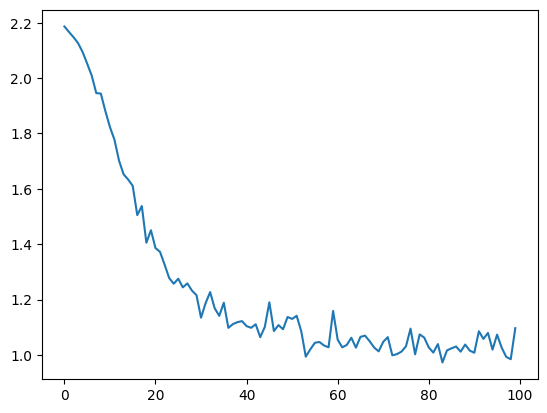

In [22]:
plt.figure()
plt.plot(all_losses)

Lots of uncertainty associated with pharmacy search, relative to blood_pressure_search, goodbye, and greeting

/tmp/ipykernel_25563/1655712744.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + intents, rotation=90)
/tmp/ipykernel_25563/1655712744.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + intents)


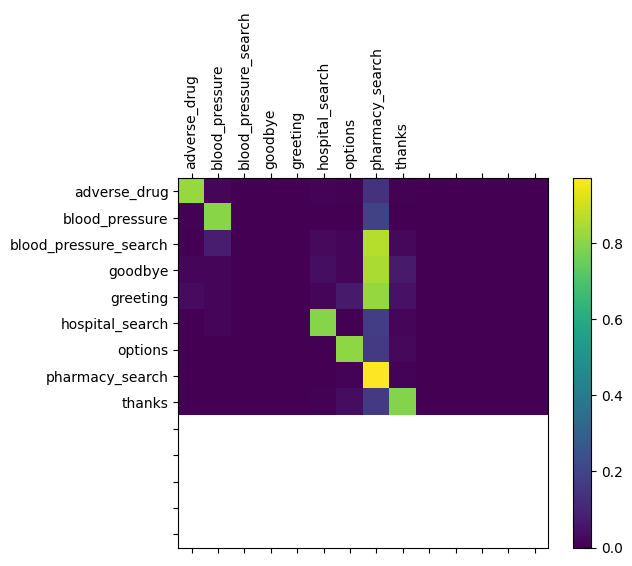

In [25]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    output, hidden = rnn(line_tensor, hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = intents.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + intents, rotation=90)
ax.set_yticklabels([''] + intents)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [26]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(torch.from_numpy(bag_of_words(input_line, words, lemmatizer)).view(1, -1))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, intents[category_index]))
            predictions.append([value, intents[category_index]])

predict('Hey there!')
predict('Thanks for that!')
predict('Find me a hospital')


> Hey there!
(-2.20) pharmacy_search
(-2.20) hospital_search
(-2.20) options

> Thanks for that!
(-0.00) thanks
(-8.30) hospital_search
(-8.30) greeting

> Find me a hospital
(-0.37) hospital_search
(-1.79) pharmacy_search
(-3.87) greeting
